In [11]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np

In [7]:
class World:
    def __init__(self, debug=False):
        self.objects = []
        self.debug = debug  # ここにロボットなどのオブジェクトを登録

    def append(self, obj):             # オブジェクトを登録するための関数
        self.objects.append(obj)

    def draw(self):
        fig = plt.figure(figsize=(4, 4))                # 8x8 inchの図を準備
        ax = fig.add_subplot(111)                      # サブプロットを準備
        ax.set_aspect('equal')                         # 縦横比を座標の値と一致させる
        ax.set_xlim(-5, 5)                              # X軸を-5m x 5mの範囲で描画
        ax.set_ylim(-5, 5)                              # Y軸も同様に
        ax.set_xlabel("X", fontsize=10)                 # X軸にラベルを表示
        ax.set_ylabel("Y", fontsize=10)                 # 同じくY軸に

        elems = []

        if self.debug:
            for i in range(1000):
                self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(
                    elems, ax), frames=100, interval=1000, repeat=False)
            plt.show()

    def one_step(self, i, elems, ax):
        while elems:
            elems.pop().remove()
        elems.append(ax.text(-4.4, 4.5, "t="+str(i), fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj,"one_step"):obj.one_step(1.0)

In [13]:
class IdealRobot:
    def __init__(self, pose, agent=None, color="black"):
        self.pose = pose
        self.r = 0.2
        self.color = color
        self.agent = agent
        self.poses = [pose]

    def draw(self, ax, elems):
        x, y, theta = self.pose
        xn = x+self.r*math.cos(theta)
        yn = y+self.r*math.sin(theta)
        elems += ax.plot([x, xn], [y, yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r,
                           fill=False, color=self.color)
        elems.append(ax.add_patch(c))

        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses], [e[1]
                                                      for e in self.poses], linewidth=0.5, color="black")

    @classmethod
    def state_transition(cls, nu, omega, time, pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose+np.array([nu*math.cos(t0), nu*math.sin(t0), omega])*time
        else:
            return pose+np.array([nu/omega*(math.sin(t0+omega*time) - math.sin(t0)),
                                  nu/omega *
                                  (-math.cos(t0+omega*time) + math.cos(t0)),
                                  omega*time])

    def one_step(self, time_interval):
        if not self.agent:
            return
        nu, omega = self.agent.decision()
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)

In [14]:
class Agent:
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega

    def decision(self, observation=None):
        return self.nu, self.omega

<IPython.core.display.Javascript object>


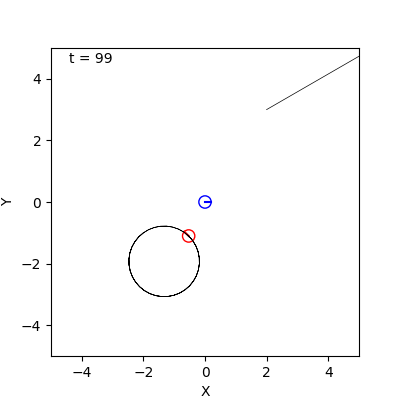

In [19]:
world = World()  # fig:class_world3
straight = Agent(0.2, 0.0)
circling = Agent(0.2, 10.0/180*math.pi)
robot1 = IdealRobot(np.array([2, 3, math.pi/6]).T, straight)
robot2 = IdealRobot(np.array([-2, -1, math.pi/5*6]).T, circling, color="red")
robot3 = IdealRobot(np.array([0, 0, 0]).T, color="blue")
world.append(robot1)
world.append(robot2)
world.append(robot3)
world.draw()